In [1]:
import pandas as pd
import glob
import os
import re
import numpy as np
import ssl
import urllib
import pathlib
from tqdm import tqdm
import logging
import traceback
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from sklearn.preprocessing import MultiLabelBinarizer
import tensorflow as tf
from tensorflow.keras import Sequential, layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
%load_ext autoreload

In [2]:
#df_yourpaintings = pd.read_csv("../raw_data/yourpaintings/painting_dataset_2021.csv")
df_yourpaintings = pd.read_csv("https://www.robots.ox.ac.uk/~vgg/data/paintings/painting_dataset_2021.csv")

URLError: <urlopen error [Errno 8] nodename nor servname provided, or not known>

In [ ]:
df_yourpaintings.head()

In [ ]:
df_yourpaintings['Labels'].nunique()

# Try to find number of unique classes

In [ ]:
#Extract filenames per URL for matching
for index, row in df_yourpaintings.iterrows():
    text = str(row["Image URL"])
    try:
        fname = text[text.rfind('/')+1:]
        df_yourpaintings.at[index,'filename']=fname    
    except Exception as e:
        logging.error(traceback.format_exc())

In [ ]:
df_yourpaintings

In [ ]:
classes_list = []
words_pattern = '[a-z]+'

for index, row in df_yourpaintings.iterrows():
    text = row["Labels"]
    words_list = re.findall(words_pattern, text, flags=re.IGNORECASE)
    for word in words_list:
        classes_list.append(word)

unique_classes = set(classes_list)
print(f"The list of unique class labels contains {len(unique_classes)} labels, namely: {unique_classes}")

## Encode data for the relevant categories

### Start by adding the list of labels to a `label_classes` column

In [ ]:
for index, row in df_yourpaintings.iterrows():
    text = str(row["Labels"])
    words_list = re.findall(words_pattern, text, flags=re.IGNORECASE)
    df_yourpaintings.at[index, "label_classes"] = words_list

In [ ]:
print(type(df_yourpaintings.loc[10]['label_classes']))
print(df_yourpaintings.loc[10]['label_classes'])
print(df_yourpaintings.loc[15]['label_classes'])

<class 'list'>
['aeroplane', 'horse']
['chair', 'diningtable', 'dog']


In [ ]:
df_yourpaintings.iloc[15]
print(len(df_yourpaintings))

8629


### Apply MultipleLabelBinarizer on the `label_classes` column

In [ ]:
mlb = MultiLabelBinarizer()

test = df_yourpaintings['label_classes']

res = pd.DataFrame(mlb.fit_transform(test),
                   columns=mlb.classes_,
                   index=test.index)

res

,aeroplane,bird,boat,chair,cow,diningtable,dog,horse,sheep,train
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
8624,0,0,1,0,0,0,0,0,0,0
8625,0,0,1,0,0,0,0,0,0,0
8626,0,1,0,0,0,0,0,0,0,0
8627,0,1,0,0,0,0,0,0,0,0


In [ ]:
res.head()

,aeroplane,bird,boat,chair,cow,diningtable,dog,horse,sheep,train
0,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1,0,0


In [ ]:
merged = pd.concat([df_yourpaintings, res], axis=1)

In [ ]:
merged.head()

,Image URL,Web page URL,Subset,Labels,filename,label_classes,aeroplane,bird,boat,chair,cow,diningtable,dog,horse,sheep,train
0,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/and-the-co...,'test',' cow',NID_QUB_QUB_264-001.jpg,[cow],0,0,0,0,1,0,0,0,0,0
1,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/0-6-00-6-0...,'train',' train',GMIII_MOSI_A1978_72_3-001.jpg,[train],0,0,0,0,0,0,0,0,0,1
2,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/044t-locom...,'train',' train',NY_NRM_1979_7964-001.jpg,[train],0,0,0,0,0,0,0,0,0,1
3,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/080-locomo...,'test',' train',CHE_CRHC_PCF40-001.jpg,[train],0,0,0,0,0,0,0,0,0,1
4,https://d3d00swyhr67nd.cloudfront.net/w1200h12...,https://artuk.org/discover/artworks/17th-and-2...,'test',' horse',NOT_NTMAG_1997_31-001.jpg,[horse],0,0,0,0,0,0,0,1,0,0


In [ ]:
merged["Image URL"].value_counts()

https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/OU/BLLI/OU_BLLI_4-001.jpg                193
https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/NID/QUB/NID_QUB_QUB_264-001.jpg            1
https://d3d00swyhr67nd.cloudfront.net/w944h944/collection/ABD/UA/ABD_UA_30191-001.jpg                  1
https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/TWMS/LAG/TWMS_LAG_TWCMS_B6379-001.jpg      1
https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/NWM/FMS/NWM_FMS_PCF51-001.jpg              1
                                                                                                    ... 
https://d3d00swyhr67nd.cloudfront.net/w944h944/collection/GAC/GAC/GAC_GAC_14965-001.jpg                1
https://d3d00swyhr67nd.cloudfront.net/w944h944/collection/STF/STKMG/STF_STKMG_1967_FA_37-001.jpg       1
https://d3d00swyhr67nd.cloudfront.net/w944h944/collection/TATE/TATE/TATE_TATE_T06878_10-001.jpg        1
https://d3d00swyhr67nd.cloudfront.net/w800h800/collecti

In [ ]:
def get_your_paintings():
    PATH = pathlib.Path("../raw_data")
    yourpaintings_path = PATH/"yourpaintings"
    yourpaintings_path.mkdir(parents=True, exist_ok=True)
    urls = df_yourpaintings['Image URL'].tolist(); urls[:5]
    for url in urls[:5]:
        fname = url[url.rfind('/')+1:]
        print(f"the url for {url} is, and the filename is {fname}")
    return urls, yourpaintings_path

urls, yourpaintings_path = get_your_paintings()
urls = pd.Series(df_yourpaintings['Image URL'], dtype="string")
urls.dtype

the url for https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/NID/QUB/NID_QUB_QUB_264-001.jpg is, and the filename is NID_QUB_QUB_264-001.jpg
the url for https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/GMIII/MOSI/GMIII_MOSI_A1978_72_3-001.jpg is, and the filename is GMIII_MOSI_A1978_72_3-001.jpg
the url for https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/NY/NRM/NY_NRM_1979_7964-001.jpg is, and the filename is NY_NRM_1979_7964-001.jpg
the url for https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/CHE/CRHC/CHE_CRHC_PCF40-001.jpg is, and the filename is CHE_CRHC_PCF40-001.jpg
the url for https://d3d00swyhr67nd.cloudfront.net/w1200h1200/collection/NOT/NTMAG/NOT_NTMAG_1997_31-001.jpg is, and the filename is NOT_NTMAG_1997_31-001.jpg


string[python]

In [ ]:
downloaded_urls_lst = []

def download(path, urls):
    # ignore SSL errors
    ssl._create_default_https_context = ssl._create_unverified_context
    for url in tqdm(urls):
        try:
            fname = url[url.rfind('/')+1:]
            downloaded_urls_lst.append(url)
            urllib.request.urlretrieve(url, path/fname)
        except Exception as e:
            logging.error(traceback.format_exc())
            
download(yourpaintings_path, urls)

  2%|▏         | 152/8629 [00:02<02:14, 63.10it/s]ERROR:root:Traceback (most recent call last):
  File "<ipython-input-20-a69195f6c481>", line 8, in download
    fname = url[url.rfind('/')+1:]
AttributeError: 'NAType' object has no attribute 'rfind'

  4%|▍         | 380/8629 [00:05<02:01, 67.85it/s]ERROR:root:Traceback (most recent call last):
  File "<ipython-input-20-a69195f6c481>", line 8, in download
    fname = url[url.rfind('/')+1:]
AttributeError: 'NAType' object has no attribute 'rfind'

  5%|▍         | 409/8629 [00:07<04:59, 27.44it/s]ERROR:root:Traceback (most recent call last):
  File "<ipython-input-20-a69195f6c481>", line 8, in download
    fname = url[url.rfind('/')+1:]
AttributeError: 'NAType' object has no attribute 'rfind'

  5%|▌         | 458/8629 [00:07<02:20, 58.18it/s]ERROR:root:Traceback (most recent call last):
  File "<ipython-input-20-a69195f6c481>", line 8, in download
    fname = url[url.rfind('/')+1:]
AttributeError: 'NAType' object has no attribute 'rfin

# Preprocess the images

In [ ]:
test = merged.copy()
imgs = []
img_path = "../raw_data/yourpaintings"

In [ ]:
for index, row in test.iterrows():
    img_file = str(row["filename"])
    try:
        image = Image.open(os.path.join(img_path, img_file))
        image = image.resize((256, 256))
        imgs.append(np.array(image))
        test.at[index, 'loaded'] = 1
    except Exception as e:
        logging.error(traceback.format_exc())    

ERROR:root:Traceback (most recent call last):
  File "<ipython-input-17-f6e12a6c1eec>", line 4, in <module>
    image = Image.open(os.path.join(img_path, img_file))
  File "/usr/local/lib/python3.7/dist-packages/PIL/Image.py", line 2843, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/yourpaintings/nan'

ERROR:root:Traceback (most recent call last):
  File "<ipython-input-17-f6e12a6c1eec>", line 4, in <module>
    image = Image.open(os.path.join(img_path, img_file))
  File "/usr/local/lib/python3.7/dist-packages/PIL/Image.py", line 2843, in open
    fp = builtins.open(filename, "rb")
FileNotFoundError: [Errno 2] No such file or directory: '../raw_data/yourpaintings/nan'

ERROR:root:Traceback (most recent call last):
  File "<ipython-input-17-f6e12a6c1eec>", line 4, in <module>
    image = Image.open(os.path.join(img_path, img_file))
  File "/usr/local/lib/python3.7/dist-packages/PIL/Image.py", line 2843, in open
    fp

In [ ]:
df_loaded = test.dropna(subset=['loaded'])

In [ ]:
df_loaded.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8447 entries, 0 to 8628
Data columns (total 17 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Image URL      8447 non-null   object 
 1   Web page URL   8447 non-null   object 
 2   Subset         8447 non-null   object 
 3   Labels         8447 non-null   object 
 4   filename       8447 non-null   object 
 5   label_classes  8447 non-null   object 
 6   aeroplane      8447 non-null   int64  
 7   bird           8447 non-null   int64  
 8   boat           8447 non-null   int64  
 9   chair          8447 non-null   int64  
 10  cow            8447 non-null   int64  
 11  diningtable    8447 non-null   int64  
 12  dog            8447 non-null   int64  
 13  horse          8447 non-null   int64  
 14  sheep          8447 non-null   int64  
 15  train          8447 non-null   int64  
 16  loaded         8447 non-null   float64
dtypes: float64(1), int64(10), object(6)
memory usage: 1.

In [ ]:
X = np.array(imgs)
X.shape

(8447, 256, 256, 3)

In [ ]:
y = df_loaded.drop(columns=['Image URL', 'Web page URL', 'Subset', 'Labels', 'label_classes', 'filename', 'loaded'])

In [ ]:
y.shape

(8447, 10)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
def load_own_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(256,256,3)))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(10, activation='sigmoid'))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='binary_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [ ]:
model = load_own_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 247, 247, 16)      4816      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 82, 82, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        32800     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 20, 20, 32)        3

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

In [ ]:
history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size = 64, 
                    epochs = 50, 
                    callbacks=[es],
                    verbose=1)

Epoch 1/50
74/74 [==============================] - 15s 100ms/step - loss: 0.4085 - accuracy: 0.2066 - val_loss: 0.3459 - val_accuracy: 0.2342
Epoch 2/50
74/74 [==============================] - 5s 71ms/step - loss: 0.3310 - accuracy: 0.2946 - val_loss: 0.3258 - val_accuracy: 0.3077
Epoch 3/50
74/74 [==============================] - 5s 71ms/step - loss: 0.3170 - accuracy: 0.3208 - val_loss: 0.3158 - val_accuracy: 0.3204
Epoch 4/50
74/74 [==============================] - 5s 74ms/step - loss: 0.3088 - accuracy: 0.3381 - val_loss: 0.3102 - val_accuracy: 0.3128
Epoch 5/50
74/74 [==============================] - 5s 71ms/step - loss: 0.3017 - accuracy: 0.3451 - val_loss: 0.3070 - val_accuracy: 0.3161
Epoch 6/50
74/74 [==============================] - 5s 71ms/step - loss: 0.2981 - accuracy: 0.3578 - val_loss: 0.3048 - val_accuracy: 0.3390
Epoch 7/50
74/74 [==============================] - 5s 71ms/step - loss: 0.2950 - accuracy: 0.3639 - val_loss: 0.3014 - val_accuracy: 0.3373
Epoch 8/50


In [ ]:
res = model.evaluate(X_test, y_test)
res

80/80 [==============================] - 2s 17ms/step - loss: 0.2912 - accuracy: 0.3751


[0.2911864221096039, 0.3751479387283325]

In [ ]:
test_accuracy = res[-1]
print(f"test_accuracy = {round(test_accuracy,2)*100} %")

test_accuracy = 38.0 %


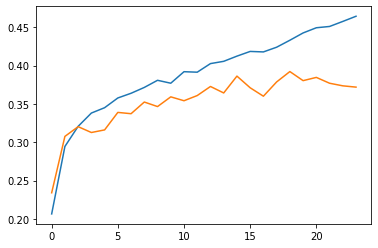

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [ ]:
model.save(img_path)

In [ ]:
from matplotlib import pyplot as plt
classes_list = ["aeroplane", "bird", "boat", "chair",	"cow", "diningtable", "dog", "horse", "sheep", "train"]
ynew = model.predict(X_test)
# show the inputs and predicted outputs
for i in range(len(X_test)):
  if i < 300:
    plt.imshow(X_test[i], interpolation='nearest')
    plt.show()
    pred_dict = dict(zip(classes_list, ynew[i]))
    print(pred_dict)

# aeroplane	bird	boat	chair	cow	diningtable	dog	horse	sheep	train

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from sklearn.metrics import accuracy_score
yhat = model.predict(X_test)
yhat = yhat.round()
# calculate accuracy
acc = accuracy_score(y_test, yhat)
# store result
print('>%.3f' % acc)
#results.append(acc)

>0.149


# Build a basic CNN architecture for benchmarking

In [ ]:
#random architecture
benchmark_model = Sequential()
# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(layers.Conv2D(128, kernel_size=7, activation='relu', input_shape=(150,150,3)))
benchmark_model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(layers.Conv2D(64, kernel_size=5, activation='relu'))
benchmark_model.add(layers.MaxPooling2D(pool_size=(4,4), strides=(2,2)))
benchmark_model.add(layers.Flatten())
benchmark_model.add(layers.Dense(128,activation='relu'))
benchmark_model.add(layers.Dense(6,activation='softmax'))
benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
benchmark_model.summary()

## Load VGG16 as baseline model

In [ ]:
def load_own_model():

    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(256,256,3)))

    model.add(layers.Conv2D(16, kernel_size=10, activation='relu'))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Conv2D(32, kernel_size=8, activation="relu"))
    model.add(layers.MaxPooling2D(3))

    model.add(layers.Conv2D(32, kernel_size=6, activation="relu"))
    model.add(layers.MaxPooling2D(3))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(100, activation='relu'))
    model.add(layers.Dense(3, activation='softmax'))
    
    opt = optimizers.Adam(learning_rate=1e-4)
    model.compile(loss='categorical_crossentropy',
                  optimizer=opt,
                  metrics=['accuracy'])
    
    return model

In [ ]:
model_homemade = load_own_model()
model_homemade.summary()

In [ ]:
es = EarlyStopping(monitor = 'val_accuracy', 
                   mode = 'max', 
                   patience = 5, 
                   verbose = 1, 
                   restore_best_weights = True)

history = model_homemade.fit(X_train, y_train,
                             validation_data = (X_val, y_val),
                             batch_size = 16, 
                             epochs = 100, 
                             callbacks=[es])

In [ ]:
res = model_homemade.evaluate(X_test, y_test)
res

In [ ]:
test_accuracy = res[-1]
print(f"test_accuracy = {round(test_accuracy,2)*100} %")